
    Target :
        Add regularization to overfit model
    Results:
        Parameters: 9,752
        Best Train Accuracy: 98.4 (17th Epoch)
        Best Train Accuracy: 99.44 (14th Epoch)
    Analysis:
        As the previous model was already regularized removing dropout 
        would help making it back to overfit. 
        ### Adding Ridge now to see the aftemath ###
        
        


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.RandomAffine((-7.0, 7.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
# Experiment-1 Reducing Parameters (set the model right). Impact: Parameters gone down/ no overfit/ low accuracy
# Experiment-2 Re-Structuring model looking at the receptive field. Impact: Parameters gone down further/ no overfit/ low accuracy
# Experiment-3 Adding BatchNorm to bump up the accuracy . Impact: limited parameters/ Overfitting/ accuracy improved
# Experiment-4 Adding Dropout to regularize. Impact: limited parameters/ no overfit/ test accuracy consistent
# Experiment-5 Restructuring model with GAP at the end of the convolutions. limited parameters/ underfit / no target acc
# Experiment-6 Reducing Dropout value to 10% as in experiment-5 it was highly penalized. Adding many transforms
# Experiment-7 Playing with LR Scheduler
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            #nn.Dropout2d(dropout_value)
        ) #input:28x28 Output:26x26 RF:3x3
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(dropout_value)
        ) #input:26x26 Output:24x24 RF:5x5

          ######################### TRANSITION BLOCK 1 ############################
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24 Output:12x12 RF:6x6

        self.conv_1x1_1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            
        ) #input:13x13 Output:12x12 RF:6x6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
           #nn.Dropout2d(dropout_value)
        ) #input:12x12 Output:10x10 RF:10x10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(dropout_value)
        ) #input:10x10 Output:8x8 RF:14x14

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(dropout_value)
        ) #input:10x10 Output:8x8 RF:18x18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout2d(dropout_value)
        ) #input:8x8 Output:6x6 RF:22x22

         ######################### TRANSITION BLOCK 2 ############################
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6 Output:1x1 RF:32x32

        self.conv_1x1_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
        )
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.conv_1x1_1(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.conv_1x1_2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,152
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
           Conv2d-12             [-1, 16, 8, 8]           2,304
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)
    
    # Calculate Loss after adding Lasso to the total loss calculated
    l1_loss_magnitude = 0
    for param in model.parameters():
      l1_loss_magnitude = l1_loss_magnitude + torch.sum(torch.abs(param))

    l1_loss = float(0.00003) * l1_loss_magnitude
    #print("L1 (Lasso) is calculated as {} ".format(l1_loss))

    # Adding regularization to the loss incurred
    loss = loss + l1_loss
    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
                            
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
# 0.0015 Best Test Acc - 99.09
# 0.003 Best Test Acc - 98.94
# 0.0001 Best Test Acc - 99.5
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0003)
lrscheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.14125220477581024 Batch_id=468 Accuracy=93.49: 100%|██████████| 469/469 [00:22<00:00, 20.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9830/10000 (98.30%)

EPOCH: 1


Loss=0.0528293140232563 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.03031652420759201 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.038406144827604294 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9914/10000 (99.14%)

EPOCH: 4


Loss=0.033569447696208954 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.06785512715578079 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:22<00:00, 20.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.06459338217973709 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.06513654440641403 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.09031280130147934 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.035360246896743774 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.04792563617229462 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9910/10000 (99.10%)

EPOCH: 11


Loss=0.07143113017082214 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.04208054021000862 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.049006424844264984 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9911/10000 (99.11%)

EPOCH: 14


Loss=0.0300045907497406 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:20<00:00, 26.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.05522722005844116 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 23.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9909/10000 (99.09%)

EPOCH: 16


Loss=0.031941723078489304 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.06160101294517517 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:21<00:00, 21.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9904/10000 (99.04%)

EPOCH: 18


Loss=0.03561929613351822 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:22<00:00, 20.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9914/10000 (99.14%)

EPOCH: 19


Loss=0.06486837565898895 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.03762923553586006 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

EPOCH: 21


Loss=0.04698697477579117 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99.20%)

EPOCH: 22


Loss=0.05816473811864853 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.23%)

EPOCH: 23


Loss=0.0282176211476326 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:22<00:00, 26.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9914/10000 (99.14%)

EPOCH: 24


Loss=0.030376367270946503 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:21<00:00, 21.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.03723693639039993 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9913/10000 (99.13%)

EPOCH: 26


Loss=0.061186783015728 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

EPOCH: 27


Loss=0.03235013037919998 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

EPOCH: 28


Loss=0.031895268708467484 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9915/10000 (99.15%)

EPOCH: 29


Loss=0.06012416630983353 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 30


Loss=0.04094832390546799 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 31


Loss=0.05058872699737549 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH: 32


Loss=0.030384261161088943 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 33


Loss=0.0438900962471962 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 34


Loss=0.06060805916786194 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 35


Loss=0.05035365745425224 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

EPOCH: 36


Loss=0.02360122837126255 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9920/10000 (99.20%)

EPOCH: 37


Loss=0.029658477753400803 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9920/10000 (99.20%)

EPOCH: 38


Loss=0.028859246522188187 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:20<00:00, 28.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

EPOCH: 39


Loss=0.05115281790494919 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:20<00:00, 24.72it/s]



Test set: Average loss: 0.0330, Accuracy: 9899/10000 (98.99%)





```
 Plotting train and test losses vs accuracies
```



Text(0.5, 1.0, 'Test Accuracy')

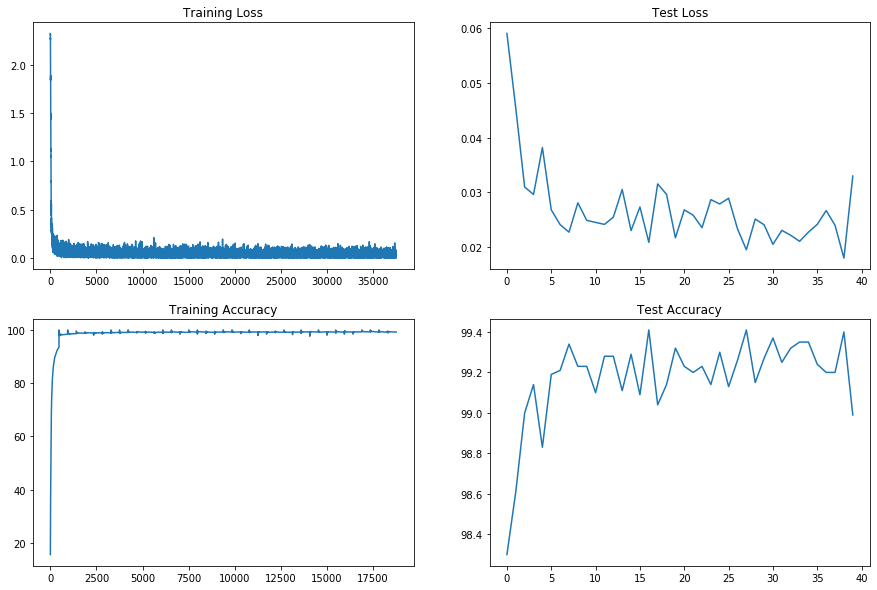

In [9]:
# Let's visualize what the plot displays

%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Misclassified images 



1 [ Predicted Value: 4, Actual Value: 9 ]


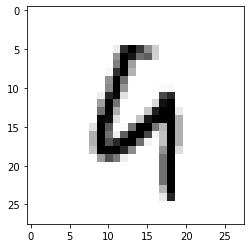



2 [ Predicted Value: 9, Actual Value: 8 ]


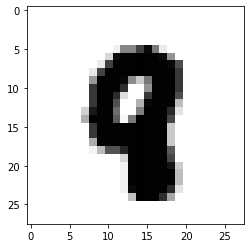



3 [ Predicted Value: 2, Actual Value: 7 ]


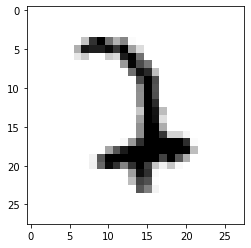



4 [ Predicted Value: 1, Actual Value: 7 ]


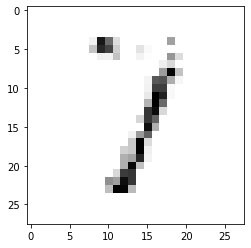



5 [ Predicted Value: 0, Actual Value: 6 ]


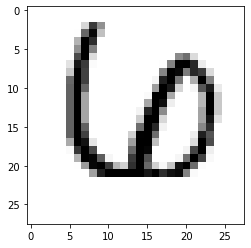



6 [ Predicted Value: 5, Actual Value: 3 ]


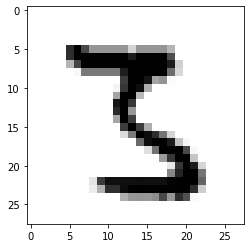



7 [ Predicted Value: 4, Actual Value: 9 ]


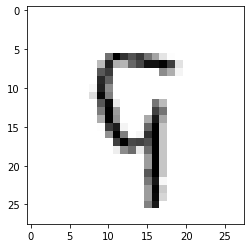



8 [ Predicted Value: 5, Actual Value: 3 ]


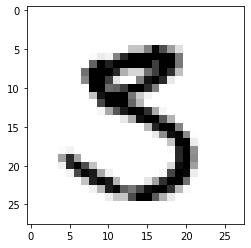



9 [ Predicted Value: 5, Actual Value: 3 ]


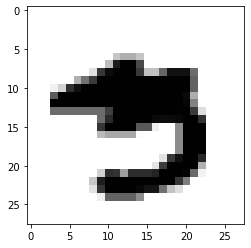



10 [ Predicted Value: 0, Actual Value: 6 ]


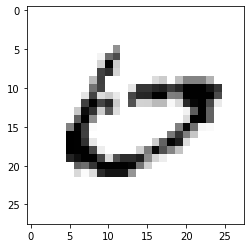



11 [ Predicted Value: 7, Actual Value: 9 ]


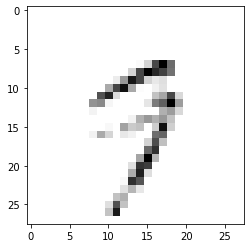



12 [ Predicted Value: 1, Actual Value: 6 ]


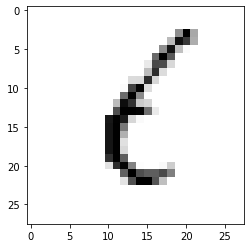



13 [ Predicted Value: 4, Actual Value: 9 ]


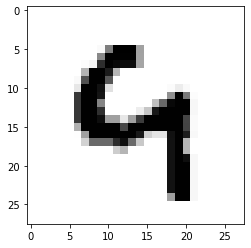



14 [ Predicted Value: 8, Actual Value: 9 ]


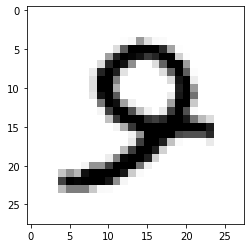



15 [ Predicted Value: 4, Actual Value: 9 ]


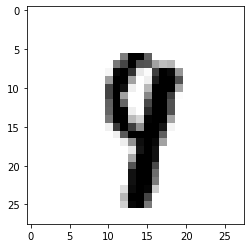



16 [ Predicted Value: 5, Actual Value: 3 ]


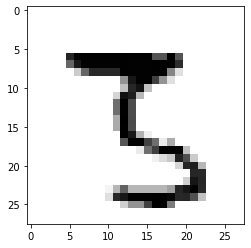



17 [ Predicted Value: 5, Actual Value: 6 ]


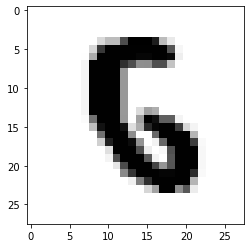



18 [ Predicted Value: 0, Actual Value: 6 ]


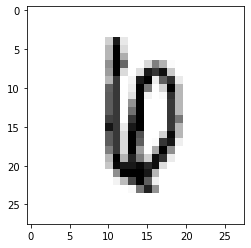



19 [ Predicted Value: 2, Actual Value: 6 ]


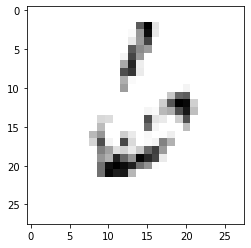



20 [ Predicted Value: 7, Actual Value: 2 ]


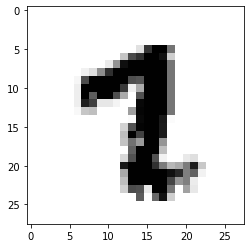



21 [ Predicted Value: 6, Actual Value: 5 ]


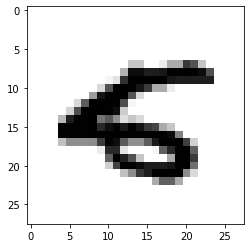



22 [ Predicted Value: 9, Actual Value: 8 ]


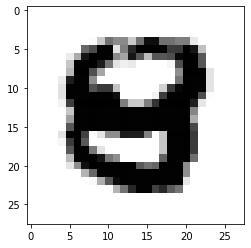



23 [ Predicted Value: 1, Actual Value: 6 ]


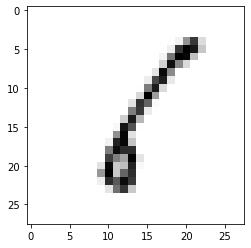



24 [ Predicted Value: 0, Actual Value: 2 ]


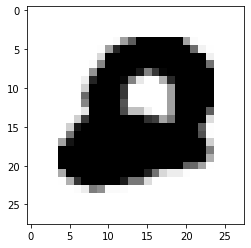



25 [ Predicted Value: 2, Actual Value: 7 ]


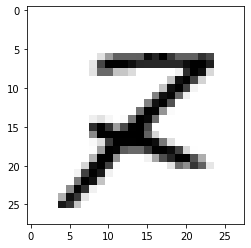



26 [ Predicted Value: 1, Actual Value: 9 ]


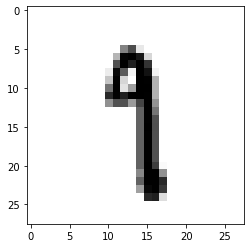



27 [ Predicted Value: 1, Actual Value: 7 ]


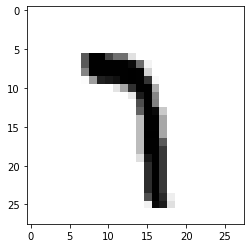



28 [ Predicted Value: 4, Actual Value: 9 ]


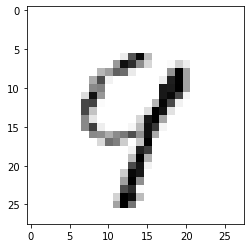



29 [ Predicted Value: 1, Actual Value: 3 ]


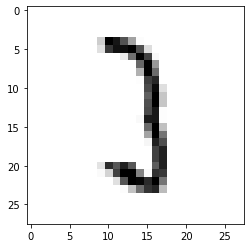



30 [ Predicted Value: 0, Actual Value: 9 ]


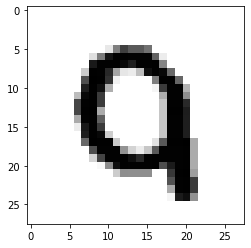



31 [ Predicted Value: 6, Actual Value: 5 ]


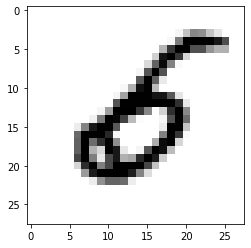



32 [ Predicted Value: 4, Actual Value: 9 ]


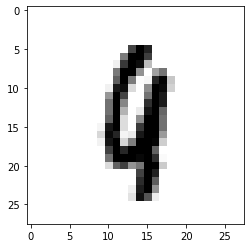



33 [ Predicted Value: 0, Actual Value: 8 ]


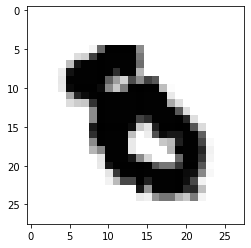



34 [ Predicted Value: 1, Actual Value: 9 ]


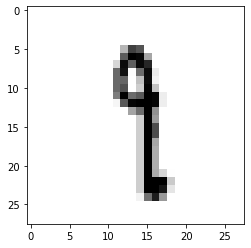



35 [ Predicted Value: 1, Actual Value: 7 ]


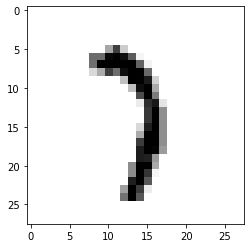



36 [ Predicted Value: 1, Actual Value: 7 ]


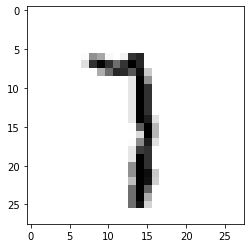



37 [ Predicted Value: 7, Actual Value: 2 ]


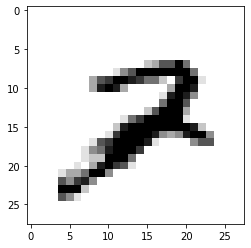



38 [ Predicted Value: 0, Actual Value: 6 ]


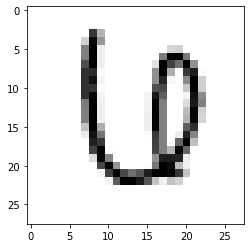



39 [ Predicted Value: 5, Actual Value: 3 ]


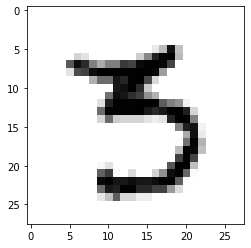



40 [ Predicted Value: 0, Actual Value: 8 ]


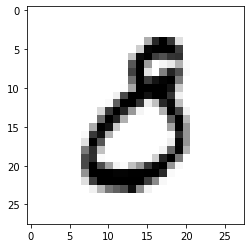



41 [ Predicted Value: 0, Actual Value: 8 ]


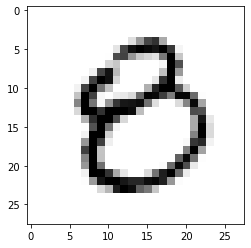



42 [ Predicted Value: 1, Actual Value: 6 ]


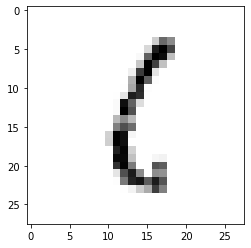



43 [ Predicted Value: 5, Actual Value: 6 ]


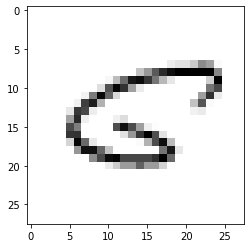



44 [ Predicted Value: 7, Actual Value: 8 ]


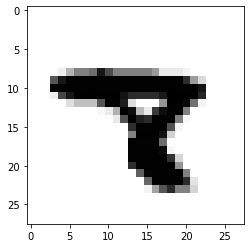



45 [ Predicted Value: 0, Actual Value: 9 ]


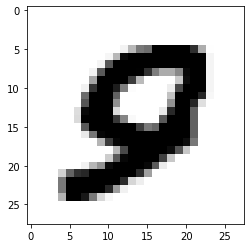



46 [ Predicted Value: 3, Actual Value: 5 ]


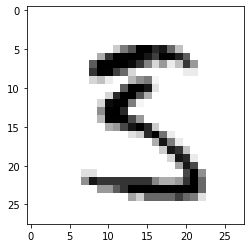



47 [ Predicted Value: 2, Actual Value: 1 ]


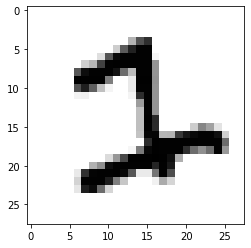



48 [ Predicted Value: 0, Actual Value: 6 ]


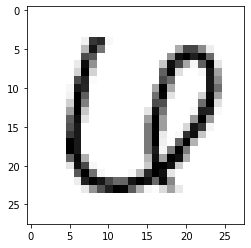



49 [ Predicted Value: 0, Actual Value: 6 ]


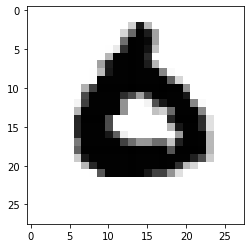



50 [ Predicted Value: 9, Actual Value: 4 ]


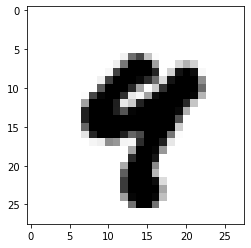



51 [ Predicted Value: 5, Actual Value: 3 ]


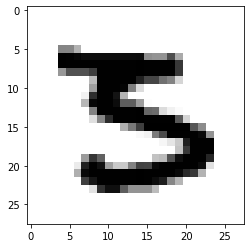



52 [ Predicted Value: 8, Actual Value: 3 ]


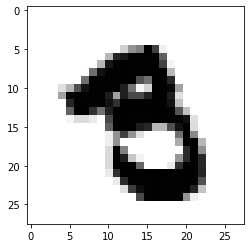



53 [ Predicted Value: 1, Actual Value: 9 ]


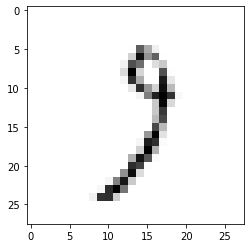



54 [ Predicted Value: 1, Actual Value: 8 ]


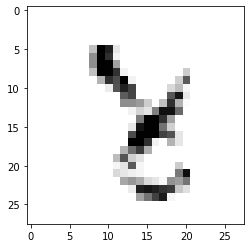



55 [ Predicted Value: 1, Actual Value: 6 ]


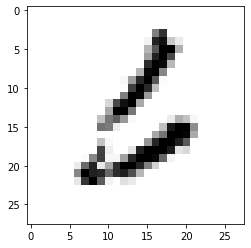



56 [ Predicted Value: 5, Actual Value: 9 ]


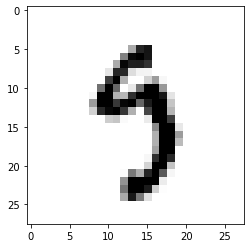



57 [ Predicted Value: 5, Actual Value: 3 ]


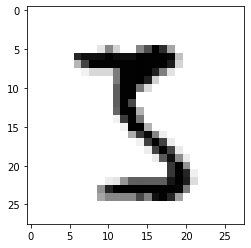



58 [ Predicted Value: 5, Actual Value: 9 ]


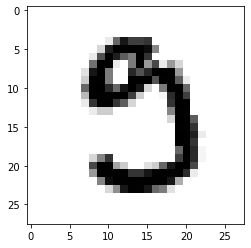



59 [ Predicted Value: 8, Actual Value: 6 ]


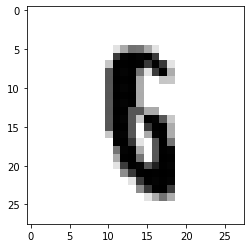



60 [ Predicted Value: 8, Actual Value: 9 ]


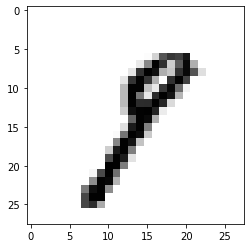



61 [ Predicted Value: 5, Actual Value: 3 ]


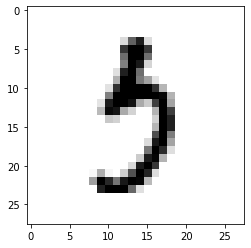



62 [ Predicted Value: 4, Actual Value: 9 ]


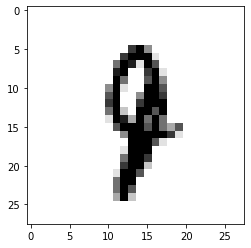



63 [ Predicted Value: 2, Actual Value: 8 ]


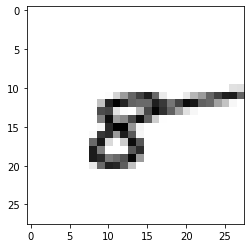



64 [ Predicted Value: 7, Actual Value: 2 ]


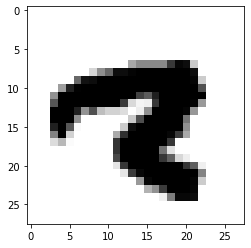



65 [ Predicted Value: 0, Actual Value: 6 ]


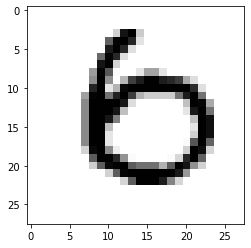



66 [ Predicted Value: 0, Actual Value: 2 ]


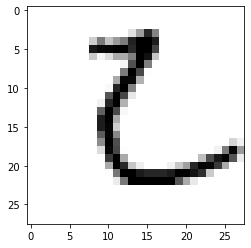



67 [ Predicted Value: 0, Actual Value: 6 ]


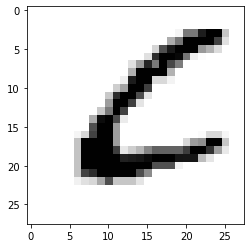



68 [ Predicted Value: 1, Actual Value: 4 ]


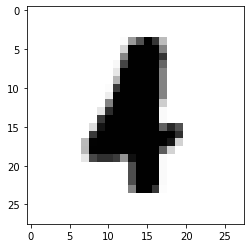



69 [ Predicted Value: 0, Actual Value: 5 ]


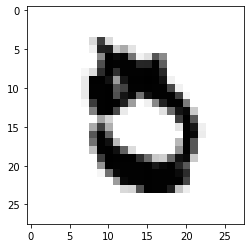



70 [ Predicted Value: 0, Actual Value: 8 ]


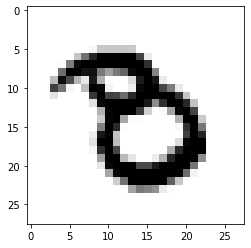



71 [ Predicted Value: 7, Actual Value: 0 ]


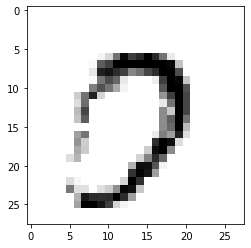



72 [ Predicted Value: 7, Actual Value: 2 ]


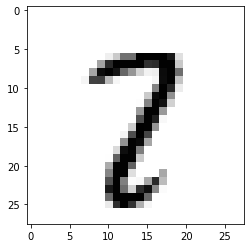



73 [ Predicted Value: 1, Actual Value: 7 ]


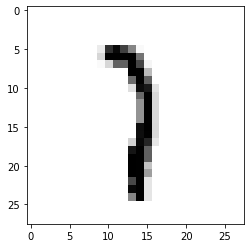



74 [ Predicted Value: 2, Actual Value: 4 ]


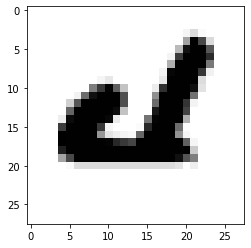



75 [ Predicted Value: 7, Actual Value: 9 ]


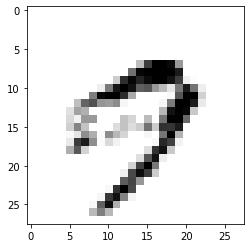



76 [ Predicted Value: 5, Actual Value: 8 ]


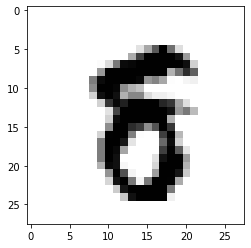



77 [ Predicted Value: 5, Actual Value: 6 ]


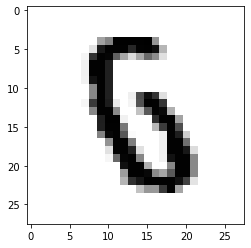



78 [ Predicted Value: 0, Actual Value: 6 ]


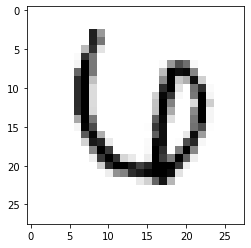



79 [ Predicted Value: 0, Actual Value: 6 ]


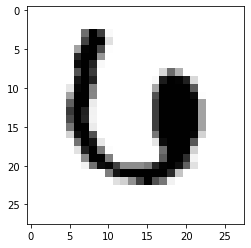



80 [ Predicted Value: 5, Actual Value: 6 ]


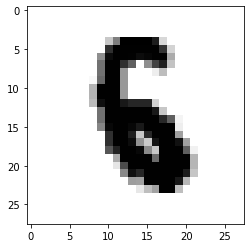



81 [ Predicted Value: 3, Actual Value: 5 ]


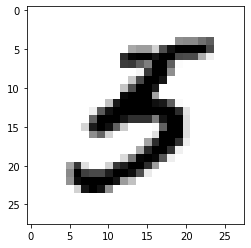



82 [ Predicted Value: 1, Actual Value: 7 ]


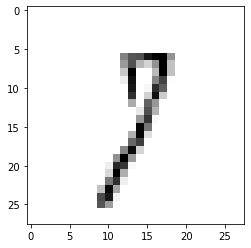



83 [ Predicted Value: 7, Actual Value: 9 ]


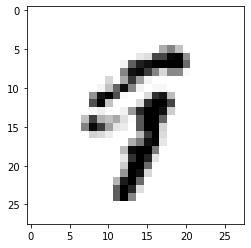



84 [ Predicted Value: 4, Actual Value: 6 ]


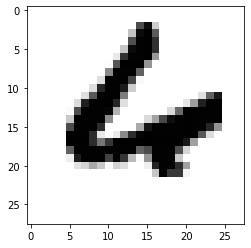



85 [ Predicted Value: 0, Actual Value: 8 ]


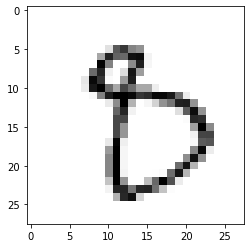



86 [ Predicted Value: 8, Actual Value: 9 ]


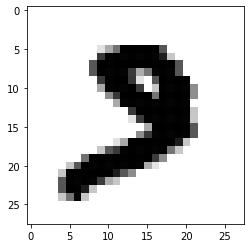



87 [ Predicted Value: 1, Actual Value: 7 ]


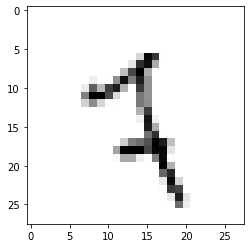



88 [ Predicted Value: 7, Actual Value: 2 ]


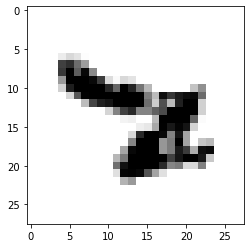



89 [ Predicted Value: 2, Actual Value: 8 ]


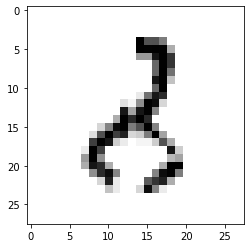



90 [ Predicted Value: 3, Actual Value: 1 ]


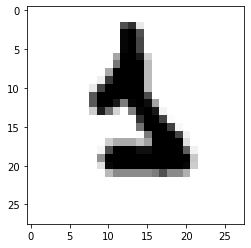



91 [ Predicted Value: 0, Actual Value: 8 ]


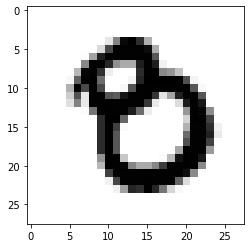



92 [ Predicted Value: 7, Actual Value: 8 ]


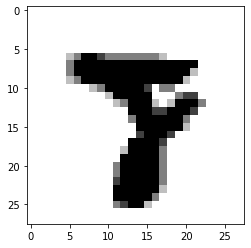



93 [ Predicted Value: 4, Actual Value: 9 ]


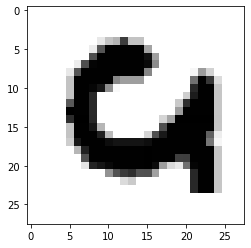



94 [ Predicted Value: 7, Actual Value: 9 ]


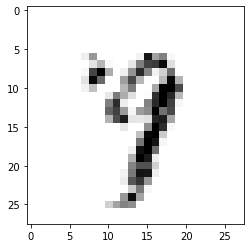



95 [ Predicted Value: 1, Actual Value: 2 ]


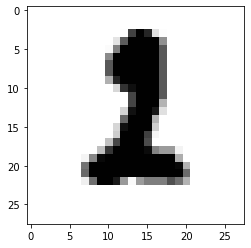



96 [ Predicted Value: 4, Actual Value: 9 ]


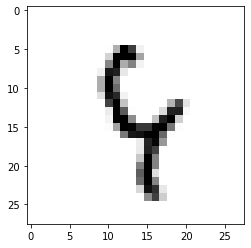



97 [ Predicted Value: 5, Actual Value: 3 ]


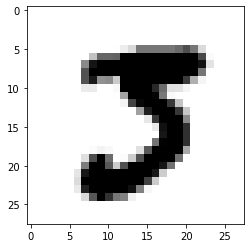



98 [ Predicted Value: 5, Actual Value: 3 ]


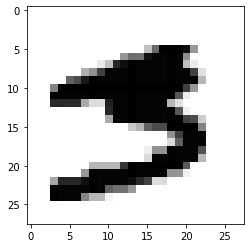



99 [ Predicted Value: 1, Actual Value: 6 ]


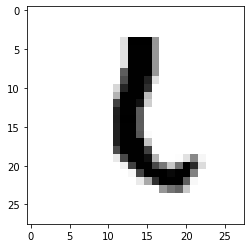



100 [ Predicted Value: 4, Actual Value: 9 ]


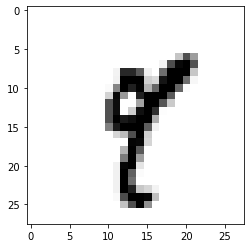



101 [ Predicted Value: 2, Actual Value: 8 ]


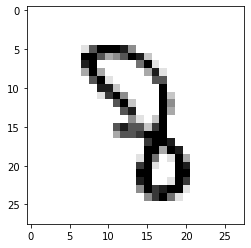

In [10]:
%matplotlib inline

def miscImages(model, device, test_loader):
    model.eval()
    test_loss = 0
    incorrect = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            for i in range(len(target)):
              if pred[i].item() != target[i]:
                incorrect += 1
                print('\n\n{} [ Predicted Value: {}, Actual Value: {} ]'.format(
                incorrect, pred[i].item(), target[i], ))
                plt.imshow(data[i].cpu().numpy().squeeze(), cmap='gray_r')
                plt.show()

miscImages(model, device, test_loader)